Ingreso de datos

In [1]:
import pandas as pd

# Cargar datos
df = pd.read_csv("train.csv")

# Mostrar información general del dataset
print("Dimensiones del dataset:", df.shape)
df.info()

# Resumen estadístico de las variables numéricas
df.describe()

# Valores faltantes por columna (ordenados)
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]


Dimensiones del dataset: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

LIMPIEZA DE DATOS

In [2]:
# Eliminar columnas 
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
df = df.drop(columns=cols_to_drop)

 #valores faltantes

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Categóricos -> valor "Desconocido"
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Desconocido')

df.isnull().sum().sort_values(ascending=False).head(10)


Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
Street         0
LotShape       0
LandContour    0
Utilities      0
LotConfig      0
dtype: int64

SEPARACION DE CARACTERISTICAS Y VARIABLE OBJETIVO

In [3]:
# Separar variables predictoras (X) y objetivo (y)
X = df.drop(columns=['SalePrice', 'Id'])  
y = df['SalePrice']

X.shape, y.shape


((1460, 74), (1460,))

DATOS DE ENTRENAMIENTO

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1168, 74), (292, 74))

CONVERTIR COLUMNAS CATEGORICAS A VALORES NUMERICOS

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identificar columnas categóricas
columnas_categoricas = X.select_dtypes(include=['object']).columns

# Crear un preprocesador para convertir variables categóricas
preprocesamiento = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ],
    remainder='passthrough' # deja las numéricas igual
)

# Crear pipeline: preprocesa y luego entrena
modelo_arbol = Pipeline(steps=[
    ('preprocesamiento', preprocesamiento),
    ('arbol', DecisionTreeRegressor(random_state=42))
])

# Entrenar
modelo_arbol.fit(X_train, y_train)

# Predicción
y_pred = modelo_arbol.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2


(26837.705479452055, np.float64(41986.95057616034), 0.7701657046824053)

CONSTRUCCION DE MODELO

In [7]:
from sklearn.ensemble import RandomForestRegressor

modelo_rf = Pipeline(steps=[
    ('preprocesamiento', preprocesamiento),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])

modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, rmse_rf, r2_rf


(17467.666626712326, np.float64(28804.831768153694), 0.8918275037097918)

Interpretación

El Random Forest predice con 89% de precisión y se equivoca en promedio $17,468, lo cual es mucho más realista y sólido.

Esto significa:

- El modelo generaliza mejor
- Los errores grandes se redujeron

VARIABLES IMPORTANTES

In [11]:
import pandas as pd
import numpy as np

# Extraer modelo Random Forest y el preprocesador del Pipeline
rf = modelo_rf.named_steps['rf']
preprocessor = modelo_rf.named_steps['preprocesamiento']

# Obtener columnas numéricas y categóricas del ColumnTransformer
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
num_features = preprocessor.transformers_[1][2]  # columnas numéricas originales

# Unir nombres de características finales
final_features = np.concatenate([num_features, cat_features])

# Importancias
importancias = rf.feature_importances_

# Crear DataFrame de importancia
importance_df = pd.DataFrame({
    'Característica': final_features,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

importance_df.head(20)


,Característica,Importancia
245,GarageFinish_Fin,0.556489
257,GarageCond_Gd,0.123829
253,GarageQual_TA,0.033713
255,GarageCond_Ex,0.030970
250,GarageQual_Fa,0.027457
254,GarageCond_Desconocido,0.027254
244,GarageFinish_Desconocido,0.017767
268,SaleType_ConLw,0.015299
267,SaleType_ConLI,0.014066
247,GarageFinish_Unf,0.013104


La tabla que aparece es el ranking de las características que más influyen en el precio de la casa, Esto significa que el estado y acabado del garaje está siendo evaluado por el modelo como una de las variables más relevantes para predecir el SalePrice del dataset.

GRAFICA DE VARIABLES

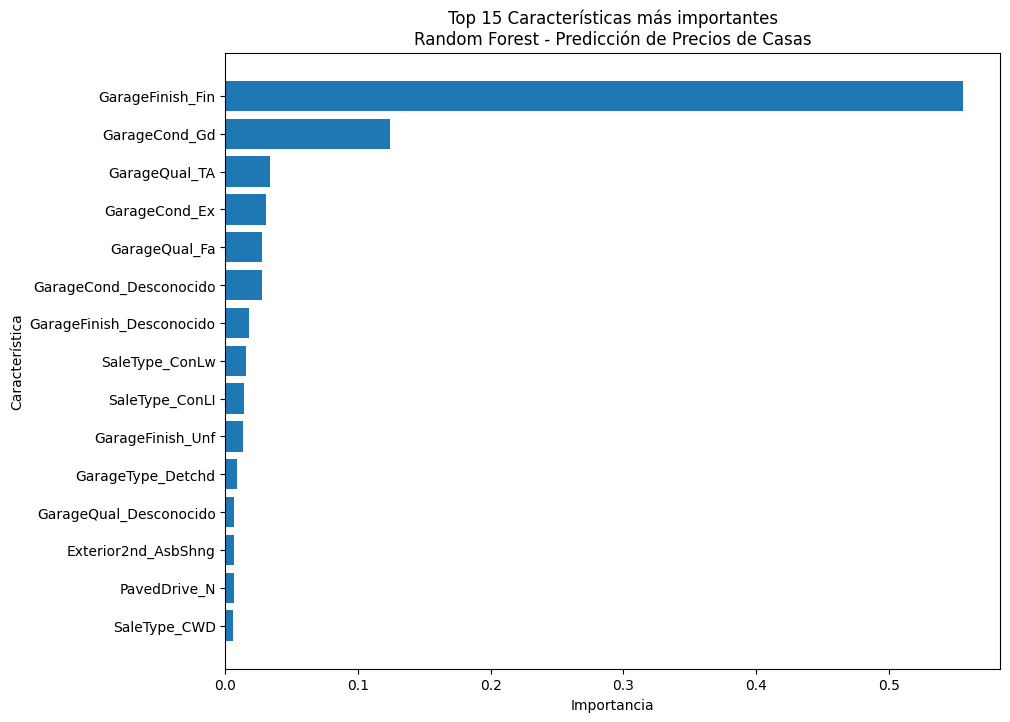

In [12]:
import matplotlib.pyplot as plt

# Top 15 características
top_n = 15
top_features = importance_df.head(top_n).sort_values('Importancia')

plt.figure(figsize=(10, 8))
plt.barh(top_features['Característica'], top_features['Importancia'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Top 15 Características más importantes\nRandom Forest - Predicción de Precios de Casas')
plt.show()


In [13]:
top20 = importance_df.head(20)
top20


,Característica,Importancia
245,GarageFinish_Fin,0.556489
257,GarageCond_Gd,0.123829
253,GarageQual_TA,0.033713
255,GarageCond_Ex,0.030970
250,GarageQual_Fa,0.027457
254,GarageCond_Desconocido,0.027254
244,GarageFinish_Desconocido,0.017767
268,SaleType_ConLw,0.015299
267,SaleType_ConLI,0.014066
247,GarageFinish_Unf,0.013104


GRAFICA DE IMPORTANCIA

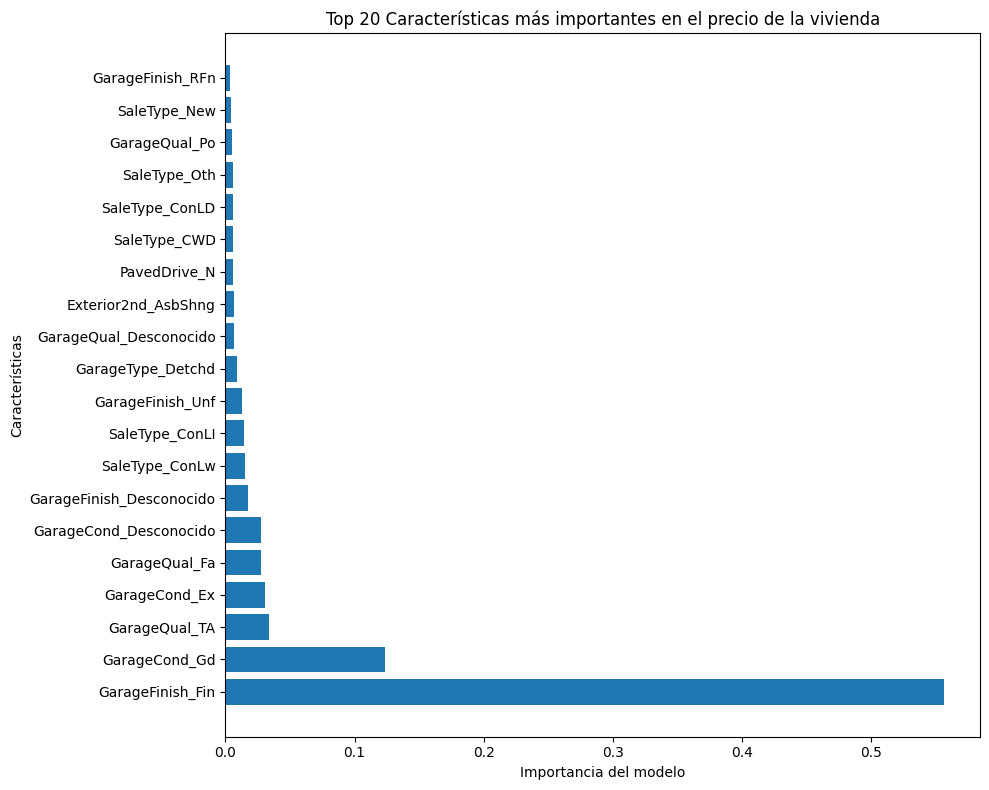

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(top20['Característica'], top20['Importancia'])
plt.title("Top 20 Características más importantes en el precio de la vivienda")
plt.xlabel("Importancia del modelo")
plt.ylabel("Características")
plt.tight_layout()
plt.show()


El modelo muestra que los atributos vinculados al garaje, como la calidad (GarageQual) y el acabado (GarageFinish), tienen un impacto significativo en el valor de la vivienda.  La calidad del sótano, el tipo de venta y los materiales externos son otros rasgos importantes que resaltan la importancia del estado estructural y del mantenimiento de la propiedad para determinar su precio final.